**Imports**

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from classiq import *
from classiq.applications.iqae.iqae import IQAE


**Global Parameters**

In [22]:
MU = 0.15
SIGMA = 0.20
CONFIDENCE = 0.95
NUM_QUBITS = 8

**Discretizing Gaussian**

In [23]:
# -----------------------------
# Gaussian return model (1 year)
# -----------------------------
mu = MU
sigma = SIGMA

# -----------------------------
# Discretization resolution
# -----------------------------
num_qubits = NUM_QUBITS
N = 2**num_qubits

# Truncation: +/- L sigma
L = 4
low = mu - L * sigma
high = mu + L * sigma

grid_points = np.linspace(low, high, N)

# Discrete probability masses from PDF samples, renormalized
pdf_vals = stats.norm.pdf(grid_points, loc=mu, scale=sigma)
probs = (pdf_vals / np.sum(pdf_vals)).tolist()

print("N =", N)
print("Truncation interval =", (low, high))
print("Sum(probs) =", sum(probs))

N = 256
Truncation interval = (-0.65, 0.9500000000000001)
Sum(probs) = 1.0


**Find a fixed “near-VaR” threshold index**

In [24]:
CONF_LEVEL = CONFIDENCE
ALPHA_VAR = 1 - CONF_LEVEL  # 0.05

# Inclusive scan: smallest idx such that sum_{i<=idx} probs[i] >= ALPHA_VAR
acc = 0.0
VAR_scan_idx = None
for idx, p in enumerate(probs):
    acc += p
    if acc >= ALPHA_VAR:
        VAR_scan_idx = idx
        break

print("ALPHA_VAR =", ALPHA_VAR)
print("threshold_idx (scan) =", VAR_scan_idx)
print("threshold_return =", grid_points[VAR_scan_idx])

# Optional: compare to continuous VaR
var_theoretical = stats.norm.ppf(ALPHA_VAR, loc=mu, scale=sigma)
print("continuous VaR return =", var_theoretical)

ALPHA_VAR = 0.050000000000000044
threshold_idx (scan) = 75
threshold_return = -0.17941176470588233
continuous VaR return = -0.17897072539029443


**State Preparation + Inclusive Tail Oracle (Classiq)**

In [25]:
GLOBAL_INDEX = 0  # set before each IQAE run

@qfunc
def load_distribution(asset: QNum):
    # Loads |psi> = sum_i sqrt(probs[i]) |i>
    inplace_prepare_state(probs, bound=0, target=asset)

@qperm
def payoff(asset: Const[QNum], ind: QBit):
    # Inclusive event: ind = 1  iff  asset <= GLOBAL_INDEX
    ind ^= asset <= GLOBAL_INDEX

@qfunc(synthesize_separately=True)
def state_preparation(asset: QNum, ind: QBit):
    load_distribution(asset)
    payoff(asset, ind)

**Oracle-call accounting helper**

In [26]:
def iqae_total_oracle_calls(iqae_result):
    total_calls = 0
    total_shots = 0
    ks = []
    shots_list = []

    for it in iqae_result.iterations_data:
        k = it.grover_iterations
        counts = it.sample_results.counts
        shots = sum(counts.values())

        ks.append(k)
        shots_list.append(shots)

        total_shots += shots
        total_calls += (k + 1) * shots

    return int(total_calls), int(total_shots), ks, shots_list

**Build IQAE**

In [27]:
iqae = IQAE(
    state_prep_op=state_preparation,
    problem_vars_size=num_qubits,
    constraints=Constraints(max_width=28),
    preferences=Preferences(machine_precision=num_qubits),
)

In [28]:
# Show circuit once if you want
# show(iqae.get_qprog())

**Sweep epsilon and collect calls**

In [ ]:
threshold_idx = VAR_scan_idx
GLOBAL_INDEX = threshold_idx

alpha_fail = 0.01   # fixed failure prob (99% confidence)
eps_list = [0.2 / (2**n) for n in range(0, 6)]  # 0.2 -> 0.00625
TRIALS = 5

raw = []  # one entry per (eps, trial)

print("\n--- Running sweep ---")
for eps in eps_list:
    for t in range(TRIALS):
        res = iqae.run(epsilon=eps, alpha=alpha_fail)

        calls, shots, ks, shots_per_iter = iqae_total_oracle_calls(res)
        L, U = res.confidence_interval

        raw.append({
            "epsilon": float(eps),
            "inv_epsilon": float(1/eps),
            "trial": int(t),
            "oracle_calls": int(calls),
            "shots": int(shots),
            "ci_half": float((U - L) / 2),
            "k_schedule": ks,
        })

    print(f"eps={eps:.6f} done")




--- Running sweep ---
eps=0.200000 done
eps=0.100000 done
eps=0.050000 done
eps=0.025000 done
eps=0.012500 done
eps=0.006250 done


**Aggregate mean oracle calls (± std) and plot vs 1/epsilon**

eps=0.006250  1/eps=  160.0  mean_calls=  62668.8  std=  7728.3  mean(CI/2)=0.00037
eps=0.012500  1/eps=   80.0  mean_calls=  27443.2  std= 23657.7  mean(CI/2)=0.00305
eps=0.025000  1/eps=   40.0  mean_calls=   8192.0  std=     0.0  mean(CI/2)=0.00473
eps=0.050000  1/eps=   20.0  mean_calls=   7782.4  std=   819.2  mean(CI/2)=0.00495
eps=0.100000  1/eps=   10.0  mean_calls=   2048.0  std=     0.0  mean(CI/2)=0.03825
eps=0.200000  1/eps=    5.0  mean_calls=   2048.0  std=     0.0  mean(CI/2)=0.03597


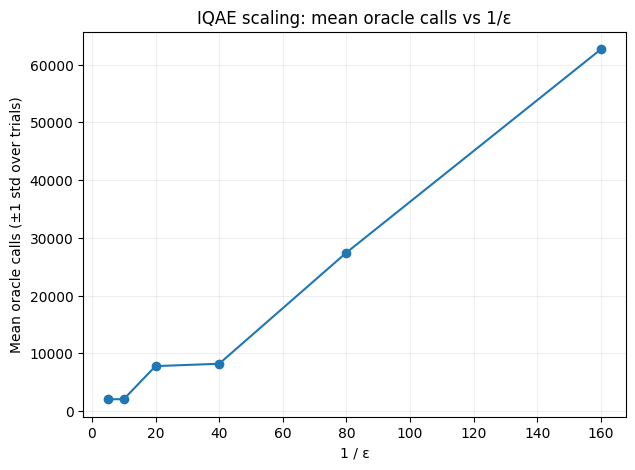

In [30]:
eps_vals = sorted(set(r["epsilon"] for r in raw))

records = []
for eps in eps_vals:
    calls = np.array([r["oracle_calls"] for r in raw if r["epsilon"] == eps], float)
    ci_half = np.array([r["ci_half"] for r in raw if r["epsilon"] == eps], float)

    records.append({
        "epsilon": float(eps),
        "inv_epsilon": float(1/eps),
        "mean_calls": float(np.mean(calls)),
        "std_calls": float(np.std(calls)),
        "mean_ci_half": float(np.mean(ci_half)),
    })

for r in records:
    print(f"eps={r['epsilon']:.6f}  1/eps={r['inv_epsilon']:7.1f}  "
          f"mean_calls={r['mean_calls']:9.1f}  std={r['std_calls']:8.1f}  "
          f"mean(CI/2)={r['mean_ci_half']:.5f}")

x = np.array([r["inv_epsilon"] for r in records], float)
y = np.array([r["mean_calls"] for r in records], float)
yerr = np.array([r["std_calls"] for r in records], float)

plt.figure(figsize=(7,5))
plt.errorbar(x, y, fmt="o-", capsize=3)
plt.xlabel("1 / ε")
plt.ylabel("Mean oracle calls (±1 std over trials)")
plt.title("IQAE scaling: mean oracle calls vs 1/ε")
plt.grid(True, alpha=0.2)
plt.show()


**Linear fit (mean calls vs 1/epsilon) + log–log slope check**

mean_calls ≈ 395.28*(1/ε) + -2388.31
log-log slope (mean calls vs eps): -1.03  (target ~ -1)


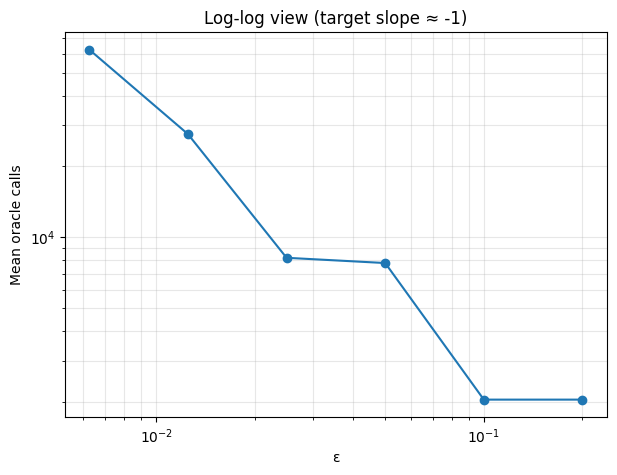

In [31]:
# Linear fit: mean_calls ~ a*(1/eps) + b
a, b = np.polyfit(x, y, 1)
print(f"mean_calls ≈ {a:.2f}*(1/ε) + {b:.2f}")

# Log-log slope: mean_calls ~ eps^slope (target slope ~ -1)
eps_arr = np.array([r["epsilon"] for r in records], float)

slope, intercept = np.polyfit(np.log(eps_arr), np.log(y), 1)
print(f"log-log slope (mean calls vs eps): {slope:.2f}  (target ~ -1)")

plt.figure(figsize=(7,5))
plt.loglog(eps_arr, y, "o-")
plt.xlabel("ε")
plt.ylabel("Mean oracle calls")
plt.title("Log-log view (target slope ≈ -1)")
plt.grid(True, which="both", alpha=0.3)
plt.show()
